In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filters
import sys, pylab, operator
%matplotlib inline

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.insert(0, caffe_root + 'python')

import caffe
import bp

In [75]:
def loadTags(filename):
    with open(filename) as f:
        reader = csv.reader(f)
        data = list(reader)
        
    tagName = [r[0] for r in data]
    return tagName, dict(zip(tagName, range(len(tagName))))

def showAttMap(img, attMap, tagName, overlap = True, blur = False):
    pylab.rcParams['figure.figsize'] = (12.0, 12.0)
    f, (ax1, ax2) = plt.subplots(1, 2)
    tagid = 0
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = transform.resize(attMap, (imgS.shape[:2]), order = 3, mode = 'nearest')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(imgS.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.8).reshape(attMap.shape + (1,))*imgS + (attMap**0.8).reshape(attMap.shape+(1,)) * attMapV;

    
    ax1.imshow(imgS)
    ax2.imshow(attMap, interpolation = 'bicubic')
    ax2.set_title(tagName)

In [8]:
caffe.set_mode_gpu()
net = caffe.Net('../models/COCO/deploy.prototxt',
                '../models/COCO/GoogleNetCOCO.caffemodel',
                caffe.TRAIN)
tags,tag2ID = loadTags('../models/COCO/catName.txt')
param = dict()
imgScale = 224
topBlobName = 'loss3/classifier'
topLayerName = 'loss3/classifier'

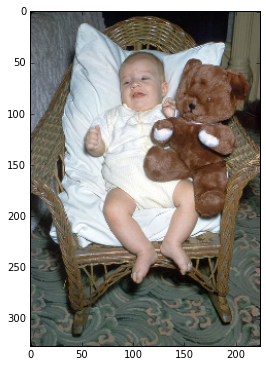

In [9]:
imgScale = 224
imgName = 'COCO_val2014_000000033066.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(imgS)

In [10]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', np.array([103.939, 116.779, 123.68]))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = 'prob')

scores = net.blobs['prob'].data[0].reshape((len(tags),-1)).max(1).flatten()
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('person', 0.41969806), ('teddy bear', 0.3837074), ('bed', 0.19042556), ('bench', 0.1241246), ('chair', 0.093076922), ('book', 0.070085779), ('couch', 0.027997846), ('handbag', 0.016974261), ('remote', 0.013473269), ('backpack', 0.010898729)]


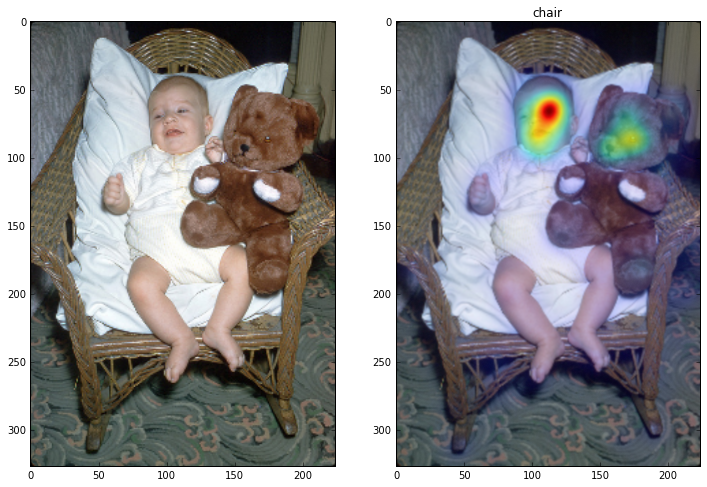

In [82]:
# Deconv Map
caffe.set_mode_dc_gpu() 
tagName = 'chair'
tagID = tag2ID[tagName]
net.blobs[topBlobName].diff[0][tagID] = net.blobs['prob'].data[0][tagID].copy()
out = net.backward(start = topLayerName)
attMap = np.abs(net.blobs['data'].diff[0]).max(0)
showAttMap(img, attMap, tagName, overlap = True, blur = True)

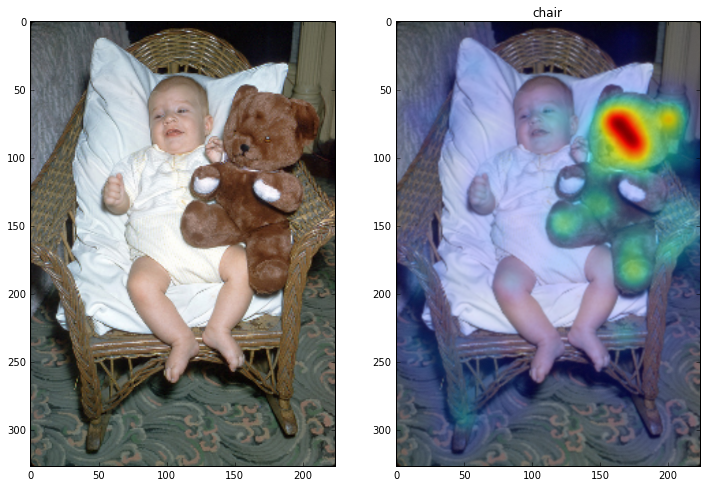

In [81]:
# Grad Map
caffe.set_mode_gpu() 
tagName = 'chair'
tagID = tag2ID[tagName]
net.blobs[topBlobName].diff[0][tagID] = net.blobs['prob'].data[0][tagID].copy()
out = net.backward(start = topLayerName)
attMap = np.abs(net.blobs['data'].diff[0]).max(0)
showAttMap(img, attMap, tagName, overlap = True, blur = True)